In [1]:
# Standard library imports
import sys

# Contributed library imports
import geopandas as gpd
import numpy as np

# Our imports
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector

sys.path.append("../..")
from constants import (
    get_IDs_to_labels,
    get_numpy_export_cf_filename,
    get_predicted_vector_labels_filename,
    get_predicted_polygons_labels_filename,
    get_mesh_filename,
    get_camera_filename,
    get_DTM_filename,
    get_numpy_export_faces_texture_filename,
    get_mesh_transform_filename,
    LABELS_COLUMN,
    LABELS_FILENAME,
    BUFFER_RADIUS_METERS,
    HEIGHT_ABOVE_GROUND_THRESH,
    GROUND_WEIGHT_POLYGON_LABELING,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
PREDICTION_SITE = "delta"
TRAINING_SITES = sorted(["chips", "lassic", "valley"])

In [3]:
IDs_TO_LABELS = get_IDs_to_labels()

In [4]:
NUMPY_EXPORT_CONFUSION_MATRIX_FILE = get_numpy_export_cf_filename(
    PREDICTION_SITE, training_sites=TRAINING_SITES, is_ortho=False
)

# Ground truth classes

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/02_photogrammetry/exports/dtms/delta.tif: 100%|██████████| 804073/804073 [00:28<00:00, 27765.75it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


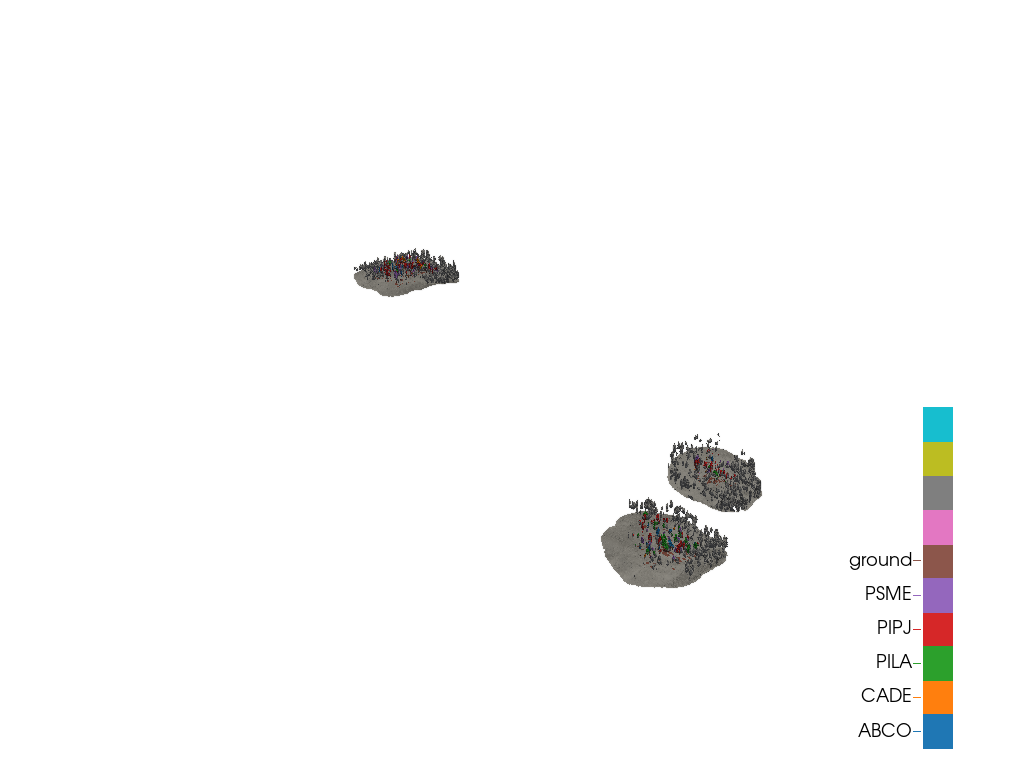

In [5]:
MESH_FILENAME = get_mesh_filename(PREDICTION_SITE)
CAMERAS_FILENAME = get_camera_filename(PREDICTION_SITE)
DTM_FILE = get_DTM_filename(PREDICTION_SITE)
TRANSFORM_FILENAME = get_mesh_transform_filename(PREDICTION_SITE)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=TRANSFORM_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)

# Per-polygon labeling using the mesh from above for convenience

Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/02_photogrammetry/exports/dtms/delta.tif: 100%|██████████| 804073/804073 [00:33<00:00, 24154.28it/s]


Weighting shape (1597521,)
Computing faces in working CRS


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
Converting faces to polygons: 100%|██████████| 1597521/1597521 [00:23<00:00, 68546.45it/s]

Creating dataframe of faces


Starting overlay


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Overlay time: 435.12020802497864
        polygon_ID  class_ID  ratio_3d_2d  face_weighting  \
0              0.0       0.0     1.041043        1.041043   
1              0.0       0.0     1.287995        1.287995   
2              0.0       2.0     1.998434        1.998434   
3              0.0       0.0     1.985930        1.985930   
4              0.0       0.0     1.258626        1.258626   
...            ...       ...          ...             ...   
340532       287.0       3.0    14.896973       14.896973   
340533       287.0       3.0    27.099898       27.099898   
340534       287.0       3.0    35.930269       35.930269   
340535       287.0       3.0     4.143348        4.143348   
340536       287.0       3.0    10.822005       10.822005   

                                                 geometry  weighted_area  
0       POLYGON ((538963.954 4542746.833, 538964.545 4...       0.530908  
1       POLYGON ((538963.954 4542746.833, 538965.401 4...       1.511210  
2       P

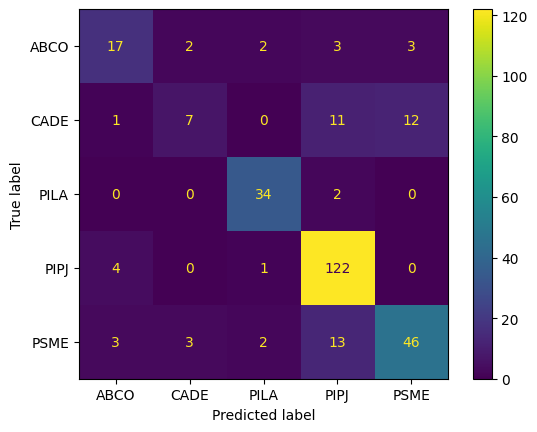

Accuracy: 0.7847222222222222


In [6]:
predicted_face_classes_filename = get_numpy_export_faces_texture_filename(
    prediction_site=PREDICTION_SITE, training_sites=TRAINING_SITES
)
# TODO consider masking no prediction faces
predicted_face_classes = np.argmax(np.load(predicted_face_classes_filename), axis=1)

ground_mask = mesh.get_height_above_ground(
    DTM_file=DTM_FILE,
    threshold=HEIGHT_ABOVE_GROUND_THRESH,
)
ground_mask_faces = mesh.vert_to_face_texture(ground_mask)

# Ground points get a weighting of 0.01, others get 1
weighting = 1 - (1 - GROUND_WEIGHT_POLYGON_LABELING) * ground_mask_faces.astype(float)

polygons = gpd.read_file(LABELS_FILENAME).query("fire==@PREDICTION_SITE")

predicted_filename = get_predicted_polygons_labels_filename(
    PREDICTION_SITE, TRAINING_SITES, False
)

print(f"Weighting shape {weighting.shape}")
predicted_class_labels = mesh.label_polygons(
    predicted_face_classes, polygons, face_weighting=weighting
)
polygons["predicted_labels"] = predicted_class_labels
polygons.to_file(predicted_filename)

gt_list = polygons[LABELS_COLUMN]
cf, classes, accuracy = compute_and_show_cf(
    pred_labels=predicted_class_labels,
    gt_labels=gt_list,
    labels=list(IDs_TO_LABELS.values()),
)
np.save(NUMPY_EXPORT_CONFUSION_MATRIX_FILE, cf)
print(f"Accuracy: {accuracy}")

# Predicted classes

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


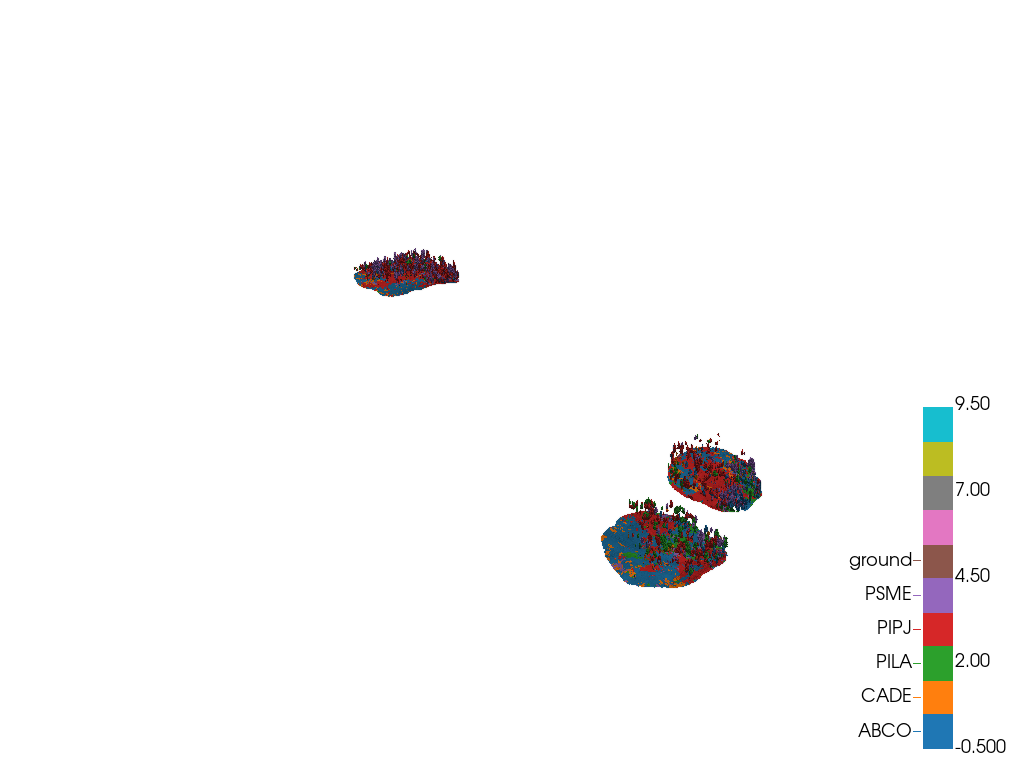

In [7]:
MESH_TRANSFORM = get_mesh_transform_filename(PREDICTION_SITE)
NUMPY_EXPORT_FACES_TEXTURE_FILE = get_numpy_export_faces_texture_filename(
    PREDICTION_SITE, training_sites=TRAINING_SITES
)
predicted_texture = np.argmax(np.load(NUMPY_EXPORT_FACES_TEXTURE_FILE), axis=1)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=MESH_TRANSFORM,
    texture=predicted_texture,
    IDs_to_labels=IDs_TO_LABELS,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

# Colored mesh

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture


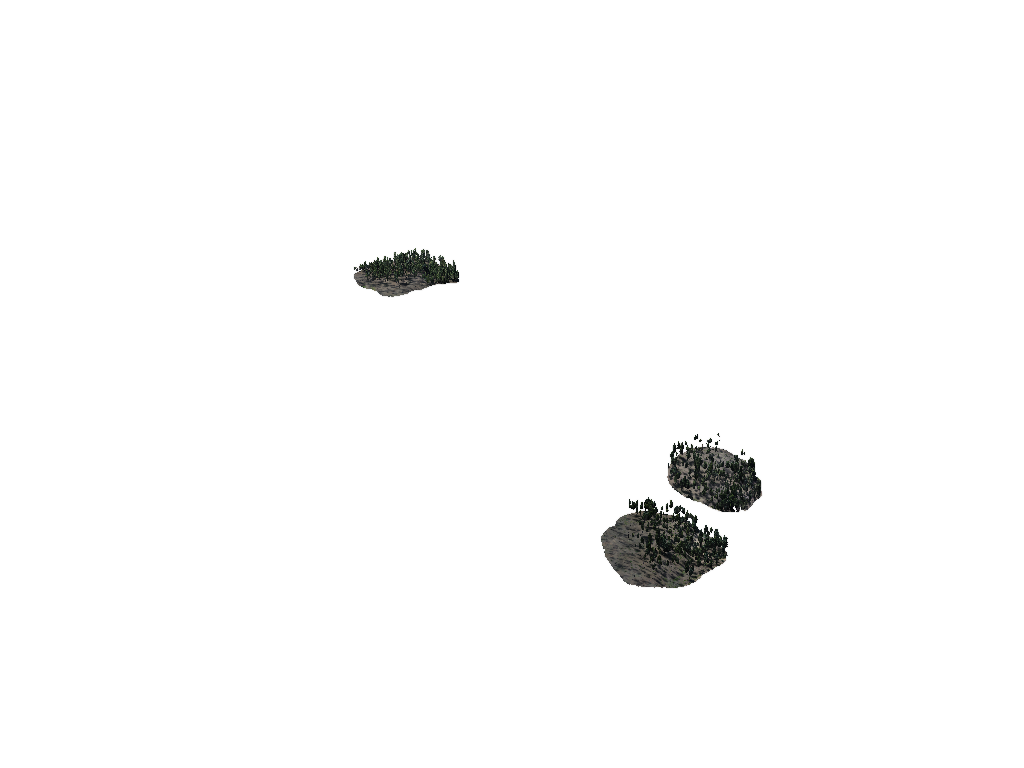

In [8]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)